# **Classification des images**

L’objectif est de développer un modèle de classification multi-label basé uniquement sur les images.

# Préparation des données

In [159]:
!pip install kaggle

In [160]:
# Importer les bibliothèques nécessaires
import os

# Charger le fichier kaggle.json (monte Google Drive ou upload le fichier)
from google.colab import files
files.upload()  # Exécute cette cellule et choisis le fichier kaggle.json

# Créer le dossier .kaggle et déplacer le fichier
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/

# Donner les permissions nécessaires
!chmod 600 /root/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [161]:
!kaggle competitions download -c multi-label-classification-competition-2023

multi-label-classification-competition-2023.zip: Skipping, found more recently modified local copy (use --force to force download)


In [162]:
import zipfile

zip_path = "/content/multi-label-classification-competition-2023.zip"
extract_path = "/content/data"

# Extraire le contenu du ZIP
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Vérifier le contenu après extraction
print(os.listdir(extract_path))


['COMP5329S1A2Dataset']


In [163]:
import pandas as pd
import os

# Chemins des fichiers
metadata_train_path = "/content/data/COMP5329S1A2Dataset/train.csv"
image_path = "/content/data/COMP5329S1A2Dataset/data/"

# Charger les fichiers CSV avec gestion des erreurs
df = pd.read_csv(metadata_train_path, on_bad_lines='skip', quoting=3)

# Supprimer les enregistrements contenant des valeurs manquantes
df = df.dropna(subset=['ImageID', 'Caption', 'Labels'])

# Nettoyer la colonne 'Labels' : remplacer les espaces par des virgules
df['Labels'] = df['Labels'].astype(str).str.replace(' ', ',')

# Transformer les labels sous forme de liste d'entiers (ex: "3,5,6" → [3,5,6])
df['Labels'] = df['Labels'].apply(lambda x: list(map(int, x.split(','))) if x else [])

# Ajouter le chemin complet des images
df['image_path'] = df['ImageID'].apply(lambda x: os.path.join(image_path, x))

# Supprimer la colonne ImageId
df = df.drop(columns=['ImageID'])

# Afficher les premières lignes pour vérifier
print(df.head())


       Labels                                            Caption  \
0         [1]  "Woman in swim suit holding parasol on sunny d...   
1     [1, 19]  "A couple of men riding horses on top of a gre...   
2         [1]  "They are brave for riding in the jungle on th...   
3  [8, 3, 13]  "a black and silver clock tower at an intersec...   
4   [8, 3, 7]  "A train coming to a stop on the tracks out si...   

                                     image_path  
0  /content/data/COMP5329S1A2Dataset/data/0.jpg  
1  /content/data/COMP5329S1A2Dataset/data/1.jpg  
2  /content/data/COMP5329S1A2Dataset/data/2.jpg  
3  /content/data/COMP5329S1A2Dataset/data/3.jpg  
4  /content/data/COMP5329S1A2Dataset/data/4.jpg  


In [164]:
# Vérifier qu'il n'y a plus d'enregistrement avec des valeurs manquantes
print(df.isnull().sum())

Labels        0
Caption       0
image_path    0
dtype: int64


In [165]:
class_names = [str(i) for i in range(1, 20) if i != 12]
print(class_names)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13', '14', '15', '16', '17', '18', '19']


In [166]:
from sklearn.model_selection import train_test_split

# Définition des proportions d'entraînement, validation et test
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

# Vérification et transformation des labels si nécessaire
df['Labels'] = df['Labels'].apply(lambda x: x if isinstance(x, list) else [int(x)])  # Assurer une liste de labels

# Séparer les données en train et (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    df['image_path'], df['Labels'], test_size=(1 - TRAIN_SPLIT), random_state=42
)

# Séparer validation et test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT), random_state=42
)

# Affichage des tailles des ensembles
print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")



Train: 20463, Validation: 4385, Test: 4385


In [167]:
import tensorflow as tf
import numpy as np

# Définition des constantes
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 18  # Nombre total de classes uniques
MAX_LABEL = 19    # Nous avons une classe 19, mais pas de classe 12

# Fonction pour encoder les labels en one-hot
def encode_labels(label_list):
    # Vérification que tous les labels sont dans la plage correcte (1 à 19, sauf 12)
    for label in label_list:
        if label < 1 or (label == 12) or label > MAX_LABEL:
            raise ValueError(f"Les labels doivent être compris entre 1 et {MAX_LABEL}, sauf 12. Label invalide : {label}")

    # Initialisation du vecteur de labels avec des zéros
    label_vector = np.zeros(NUM_CLASSES, dtype=np.float32)

    # Encodage des labels en one-hot
    for label in label_list:
        # Si label est supérieur ou égal à 12, on doit ajuster l'index pour ignorer la classe 12
        if label >= 12:
            label_vector[label - 2] = 1  # Décalage de 1 pour ignorer la classe 12
        else:
            label_vector[label - 1] = 1  # Normalement, on place la classe dans sa position

    return label_vector

def apply_encoding(labels_data):
    """
    Fonction pour appliquer l'encodage des labels tout en filtrant les exemples invalides.
    """
    encoded_data = []
    for labels in labels_data:
        try:
            # Essayer d'encoder les labels, s'il y a une erreur, ignorer cet exemple
            encoded_label = encode_labels(labels)
            encoded_data.append(encoded_label)
        except ValueError as e:
            # Si un label est invalide, afficher l'erreur et ignorer cet exemple
            print(f"Erreur d'encodage pour les labels {labels}: {e}")
            continue

    return np.array(encoded_data)

# Appliquer l'encodage des labels tout en ignorant les exemples invalides
y_train_encoded = apply_encoding(y_train)
y_val_encoded = apply_encoding(y_val)
y_test_encoded = apply_encoding(y_test)

# Vérification des dimensions après encodage
print(f"Dimensions y_train_encoded: {y_train_encoded.shape}")
print(f"Dimensions y_val_encoded: {y_val_encoded.shape}")
print(f"Dimensions y_test_encoded: {y_test_encoded.shape}")

# Fonction de prétraitement des images
def preprocess_image(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalisation [0,1]
    return img, label

# Création des datasets TensorFlow avec labels encodés
train_dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train_encoded))
    .shuffle(buffer_size=len(X_train))  # Mélanger les données
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)  # Prétraitement
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val_encoded))
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test_encoded))
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


Dimensions y_train_encoded: (20463, 18)
Dimensions y_val_encoded: (4385, 18)
Dimensions y_test_encoded: (4385, 18)


# Conception du CNN

In [168]:
from keras import models, layers, regularizers
from keras.optimizers import Adam

def build_custom_cnn(input_shape=(224, 224, 3), num_classes=18):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Première couche de convolution
        layers.Conv2D(32, (3, 3), activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Deuxième couche de convolution
        layers.Conv2D(64, (3, 3), activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Troisième couche de convolution
        layers.Conv2D(128, (3, 3), activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Couches supplémentaires
        layers.Conv2D(128, (3, 3), activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),

        # Couche dense
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),

        # Couche de sortie
        layers.Dense(num_classes, activation='sigmoid')
    ])

    return model

# Création du modèle
custom_cnn = build_custom_cnn()
custom_cnn.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 18)                  │           2,322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,455,954 (13.18 MB)

 Trainable params: 3,455,250 (13.18 MB)

 Non-trainable params: 704 (2.75 KB)

In [169]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Collect true labels and predictions
def get_true_pred_test(model, test_data):
    y_true = []
    y_pred = []

    for images, labels in test_data:
        preds = model.predict(images)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    return y_true, y_pred

def get_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred, target_names=class_names))
    print("Confusion Matrix:")
    print(cm)
    return cm

def plot_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [170]:
import numpy as np

# Fonction pour convertir les labels multi-labels en un tableau binaire
def convert_to_binary_matrix(y, num_classes=19):
    binary_labels = np.zeros((len(y), num_classes), dtype=np.float32)
    for i, labels in enumerate(y):
        for label in labels:
            binary_labels[i, label - 1] = 1  # Ajuster le label (1, 2, ..., 19)
    return binary_labels

# Conversion de y_train en matrice binaire
y_train_binary = convert_to_binary_matrix(y_train, num_classes=19)

# Exclure la classe 12 (index 11) et calculer les poids des classes restantes
class_counts = np.sum(y_train_binary, axis=0)  # Somme des occurrences de chaque classe
class_counts = np.delete(class_counts, 11)  # Exclure la classe 12 (index 11)

# Protection contre les classes absentes (éviter la division par zéro)
class_counts[class_counts == 0] = 1.0  # Remplacer les zéros par 1 pour éviter la division par zéro

# Calcul des poids des classes : inverse de la fréquence des classes
class_weights = 1.0 / class_counts  # Inverse des occurrences pour obtenir les poids
class_weights /= np.sum(class_weights)  # Normaliser les poids pour éviter des valeurs trop grandes

# Affichage des poids des classes
print("Poids des classes (après exclusion de la classe 12):", class_weights)

# Calcul des poids pour chaque échantillon
def compute_sample_weights(y_train_binary, class_weights):
    sample_weights = np.zeros(len(y_train_binary), dtype=np.float32)

    for i, labels in enumerate(y_train_binary):
        # Trouver les classes positives (où y_train_binary[i] == 1)
        sample_classes = np.where(labels == 1)[0]

        # Ajustement CORRIGÉ des indices pour exclure la classe 12 (index 11)
        # Classes avant 11: inchangé, classes après 11: décalage de -1
        sample_classes_adjusted = [c if c < 11 else c - 1 for c in sample_classes]

        # Calculer le poids moyen des classes ajustées
        sample_weight = np.mean([class_weights[c] for c in sample_classes_adjusted])

        # Affecter ce poids à l'échantillon
        sample_weights[i] = sample_weight

    return sample_weights

# Calculer les poids pour chaque échantillon
sample_weights = compute_sample_weights(y_train_binary, class_weights)

# Affichage des poids des échantillons pour les 5 premiers exemples
print("Poids des échantillons pour les 5 premiers exemples:", sample_weights[:5])

Poids des classes (après exclusion de la classe 12): [0.00247476 0.04989164 0.01294106 0.04448863 0.04989164 0.04039344
 0.04755681 0.02559054 0.0562098  0.0392042  0.09372848 0.09372848
 0.22849782 0.0298194  0.05304414 0.04039344 0.03674227 0.05540334]
Poids des échantillons pour les 5 premiers exemples: [0.00247476 0.0372429  0.00247476 0.00247476 0.00247476]


In [171]:
from tensorflow.keras import layers, models, optimizers, callbacks
import tensorflow as tf
from tensorflow.keras import backend as K

# Define training parameters
EPOCHS = 20
LEARNING_RATE = 1e-6

def compile_and_train(model, model_name, train_ds, val_ds, epochs=EPOCHS):
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc', multi_label=True),
            tf.keras.metrics.F1Score(name='f1_score', threshold=0.5, average='macro')
        ]
    )

    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    print(f"\nTraining {model_name}...\n")

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stop]
    )
    return history

def create_weighted_dataset(dataset, sample_weights):
    # Convertir les sample_weights en Dataset
    weights_dataset = tf.data.Dataset.from_tensor_slices(sample_weights)

    # Fusionner avec le Dataset original
    weighted_dataset = tf.data.Dataset.zip((dataset, weights_dataset))

    # Reconstruire la structure (features, labels, weights)
    weighted_dataset = weighted_dataset.map(
        lambda data, weight: (data[0], data[1], weight),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return weighted_dataset


In [172]:
weighted_train_dataset = create_weighted_dataset(train_dataset, sample_weights)

history_custom_cnn =compile_and_train(custom_cnn, "Custom CNN", weighted_train_dataset, val_dataset, epochs=EPOCHS)


Training Custom CNN...

Epoch 1/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.2442 - auc: 0.4993 - f1_score: 0.1152 - loss: 0.5276 - val_accuracy: 0.5948 - val_auc: 0.5004 - val_f1_score: 0.0945 - val_loss: 0.8540
Epoch 2/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.5169 - auc: 0.5012 - f1_score: 0.1039 - loss: 0.5075 - val_accuracy: 0.7273 - val_auc: 0.5142 - val_f1_score: 0.0662 - val_loss: 0.7458
Epoch 3/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.5716 - auc: 0.5117 - f1_score: 0.1016 - loss: 0.4915 - val_accuracy: 0.7389 - val_auc: 0.5343 - val_f1_score: 0.0591 - val_loss: 0.7126
Epoch 4/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.5992 - auc: 0.5280 - f1_score: 0.1002 - loss: 0.4743 - val_accuracy: 0.7453 - val_auc: 0.5534 - val_f1_score: 0.0579 - val_loss: 0.6856
Epoch 5/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.6096 - auc: 0.5386 - f1_score: 0.1050 - loss: 0.4564 - val_accuracy: 0.7441 - val_auc: 0.56

In [173]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score

def plot_history(history, model_name):
    # Récupérer les données d'historique
    metrics = history.history
    epochs_range = range(1, len(metrics['loss']) + 1)

    # Création des graphiques
    plt.figure(figsize=(18, 6))

    # Subplot 1: Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, metrics['loss'], label='Training Loss')
    plt.plot(epochs_range, metrics['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} - Loss')

    # Subplot 2: F1 Score (macro)
    plt.subplot(1, 3, 2)
    if 'f1_score' in metrics:
        plt.plot(epochs_range, metrics['f1_score'], label='Training F1')
        plt.plot(epochs_range, metrics['val_f1_score'], label='Validation F1')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.title(f'{model_name} - F1 Score (macro)')
    else:
        plt.text(0.5, 0.5, 'F1 Score data not available',
                horizontalalignment='center', verticalalignment='center')
        plt.title('F1 Score not tracked')

    # Subplot 3: AUC
    plt.subplot(1, 3, 3)
    if 'auc' in metrics:
        plt.plot(epochs_range, metrics['auc'], label='Training AUC')
        plt.plot(epochs_range, metrics['val_auc'], label='Validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()
        plt.title(f'{model_name} - AUC')
    else:
        plt.text(0.5, 0.5, 'AUC data not available',
                horizontalalignment='center', verticalalignment='center')
        plt.title('AUC not tracked')

    plt.tight_layout()
    plt.show()

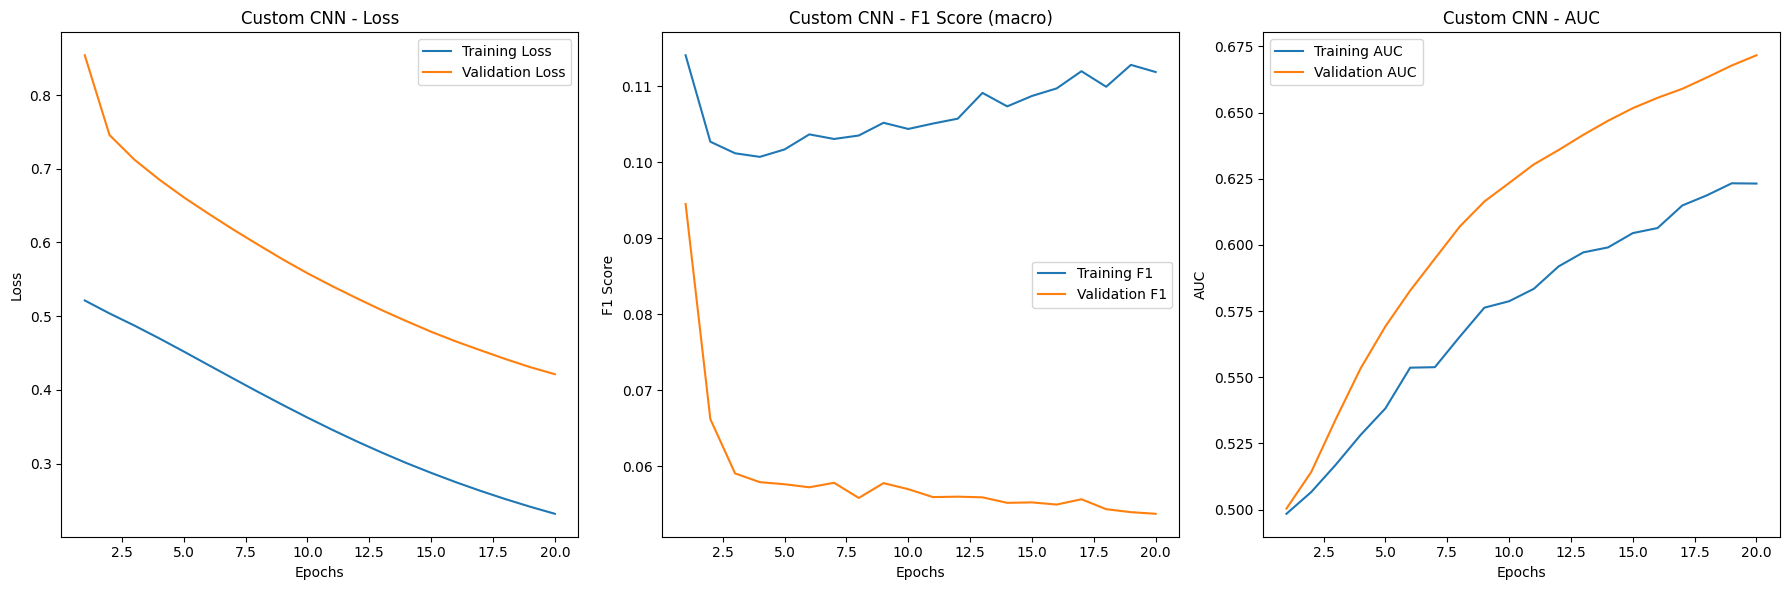

In [174]:
plot_history(history_custom_cnn, "Custom CNN")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


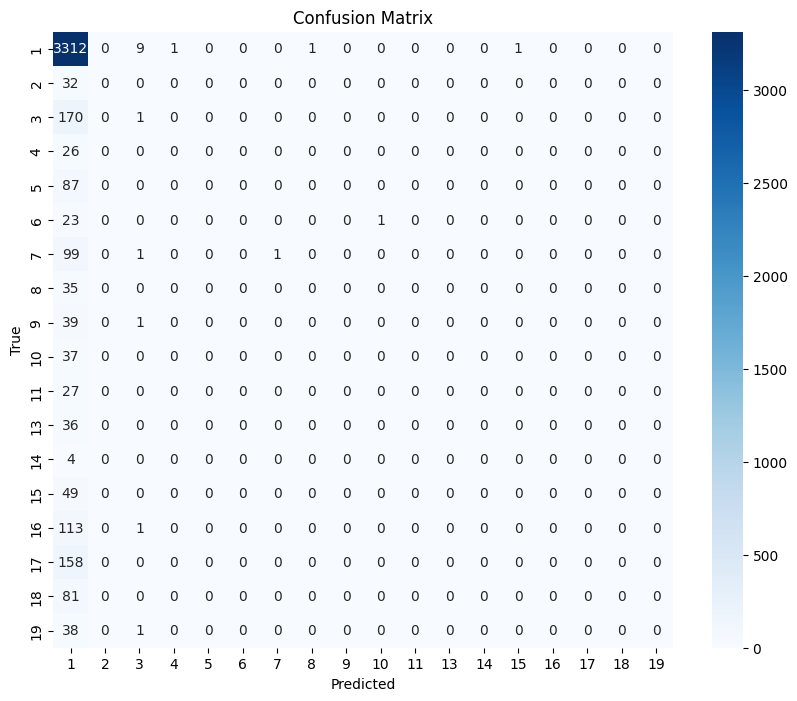

In [175]:
y_true, y_pred = get_true_pred_test(custom_cnn, test_dataset)
cm = get_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names)

# Expérimentations avec des architectures CNN avancées

Nous allons tout d'abord choisir deux architectures vues en cours. J'ai donc porté mon choix sur VGG et EfficientNet.

**VGG16 :**

Expérimentation 1 : Transfert d’apprentissage

In [176]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

def create_vgg16_model(input_shape=(224, 224, 3), num_classes=18):
    # Charger VGG16 sans la tête fully connected
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)

    # Geler les couches convolutionnelles (extracteur de caractéristiques)
    base_model.trainable = False

    # Ajouter la nouvelle tête de classification
    x = GlobalAveragePooling2D()(base_model.output)  # Remplace Flatten()
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation="sigmoid")(x)

    # Définir le modèle final
    model = Model(inputs=base_model.input, outputs=x)

    return model

# Création et affichage du modèle
vgg16_model = create_vgg16_model()
vgg16_model.summary()


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │          65,6

 Total params: 14,782,674 (56.39 MB)

 Trainable params: 67,986 (265.57 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [177]:
history_vgg16_model =compile_and_train(vgg16_model, "VGG16 transfer learning", weighted_train_dataset, val_dataset, epochs=EPOCHS)


Training VGG16 transfer learning...

Epoch 1/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 70s 103ms/step - accuracy: 0.1329 - auc: 0.5068 - f1_score: 0.1218 - loss: 0.0155 - val_accuracy: 0.1790 - val_auc: 0.5237 - val_f1_score: 0.0993 - val_loss: 0.7268
Epoch 2/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 61s 96ms/step - accuracy: 0.1655 - auc: 0.5032 - f1_score: 0.1186 - loss: 0.0149 - val_accuracy: 0.3537 - val_auc: 0.5258 - val_f1_score: 0.0938 - val_loss: 0.6984
Epoch 3/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 62s 96ms/step - accuracy: 0.1930 - auc: 0.5102 - f1_score: 0.1183 - loss: 0.0144 - val_accuracy: 0.5138 - val_auc: 0.5290 - val_f1_score: 0.0890 - val_loss: 0.6713
Epoch 4/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 62s 96ms/step - accuracy: 0.2256 - auc: 0.5018 - f1_score: 0.1184 - loss: 0.0138 - val_accuracy: 0.6415 - val_auc: 0.5315 - val_f1_score: 0.0863 - val_loss: 0.6454
Epoch 5/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 62s 96ms/step - accuracy: 0.2554 - auc: 0.5100 - f1_score: 0.1195 - loss: 0.0133 - val_accuracy: 0.7120 -

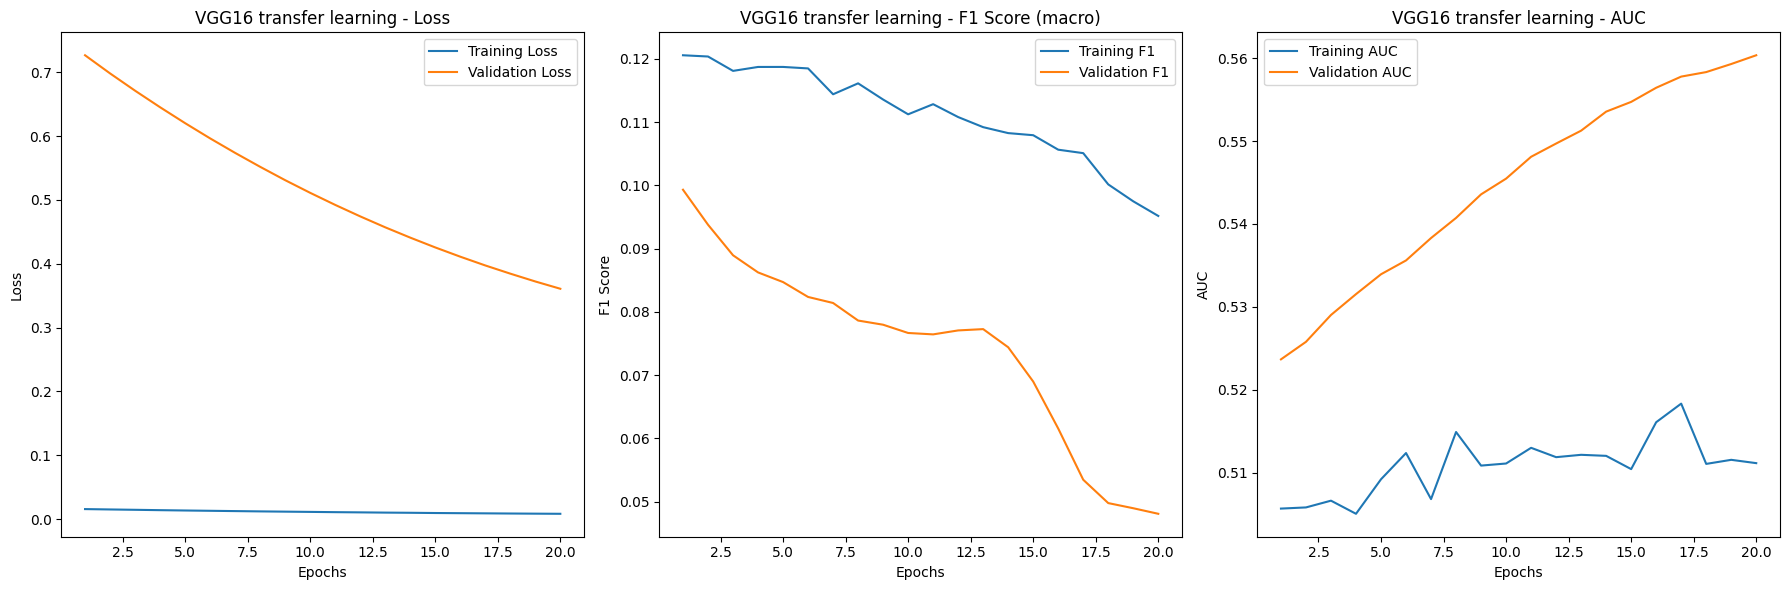

In [178]:
plot_history(history_vgg16_model, "VGG16 transfer learning")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


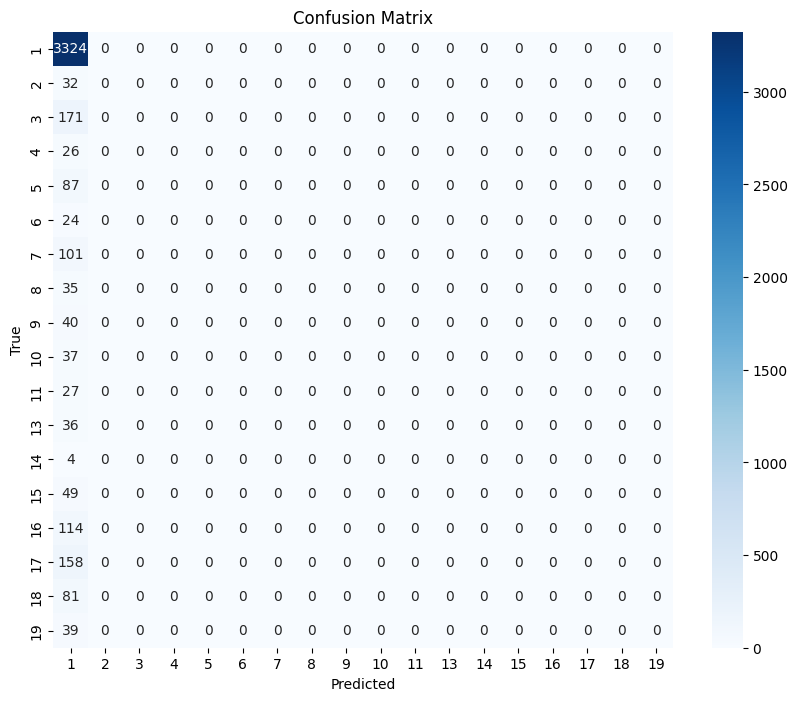

In [179]:
y_true, y_pred = get_true_pred_test(vgg16_model, test_dataset)
cm = get_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names)

Expérimentation 2 : Fine-tuning partiel

In [180]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam

def create_vgg16_finetuned_2(input_shape=(224, 224, 3), num_classes=18):
    # Charger le modèle VGG16 avec les poids d'ImageNet
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)

    # Débloquer certaines couches pour le fine-tuning
    for layer in base_model.layers[-4:]:  # On déverrouille les 4 dernières couches
        layer.trainable = True

    # Ajouter des couches personnalisées
    x = Flatten()(base_model.output)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation="softmax")(x)

    # Définir le modèle final
    model = Model(inputs=base_model.input, outputs=x)

    return model

# Création du modèle
vgg16_finetuned_model_2 = create_vgg16_finetuned_2()
vgg16_finetuned_model_2.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,928,402 (68.39 MB)

 Trainable params: 17,928,402 (68.39 MB)

 Non-trainable params: 0 (0.00 B)

In [181]:
history_vgg16_model_2 = compile_and_train(vgg16_finetuned_model_2, "VGG16 fine-tuning", weighted_train_dataset, val_dataset, epochs=EPOCHS)


Training VGG16 fine-tuning...

Epoch 1/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 69s 102ms/step - accuracy: 0.5966 - auc: 0.5223 - f1_score: 0.0993 - loss: 0.0079 - val_accuracy: 0.7542 - val_auc: 0.5618 - val_f1_score: 0.0478 - val_loss: 0.3491
Epoch 2/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 61s 96ms/step - accuracy: 0.6061 - auc: 0.5117 - f1_score: 0.0939 - loss: 0.0077 - val_accuracy: 0.7542 - val_auc: 0.5625 - val_f1_score: 0.0478 - val_loss: 0.3386
Epoch 3/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 62s 96ms/step - accuracy: 0.6145 - auc: 0.5072 - f1_score: 0.0942 - loss: 0.0076 - val_accuracy: 0.7542 - val_auc: 0.5634 - val_f1_score: 0.0478 - val_loss: 0.3288
Epoch 4/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 62s 96ms/step - accuracy: 0.6116 - auc: 0.5147 - f1_score: 0.0914 - loss: 0.0074 - val_accuracy: 0.7542 - val_auc: 0.5641 - val_f1_score: 0.0478 - val_loss: 0.3198
Epoch 5/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 62s 96ms/step - accuracy: 0.6266 - auc: 0.5171 - f1_score: 0.0883 - loss: 0.0071 - val_accuracy: 0.7542 - val_a

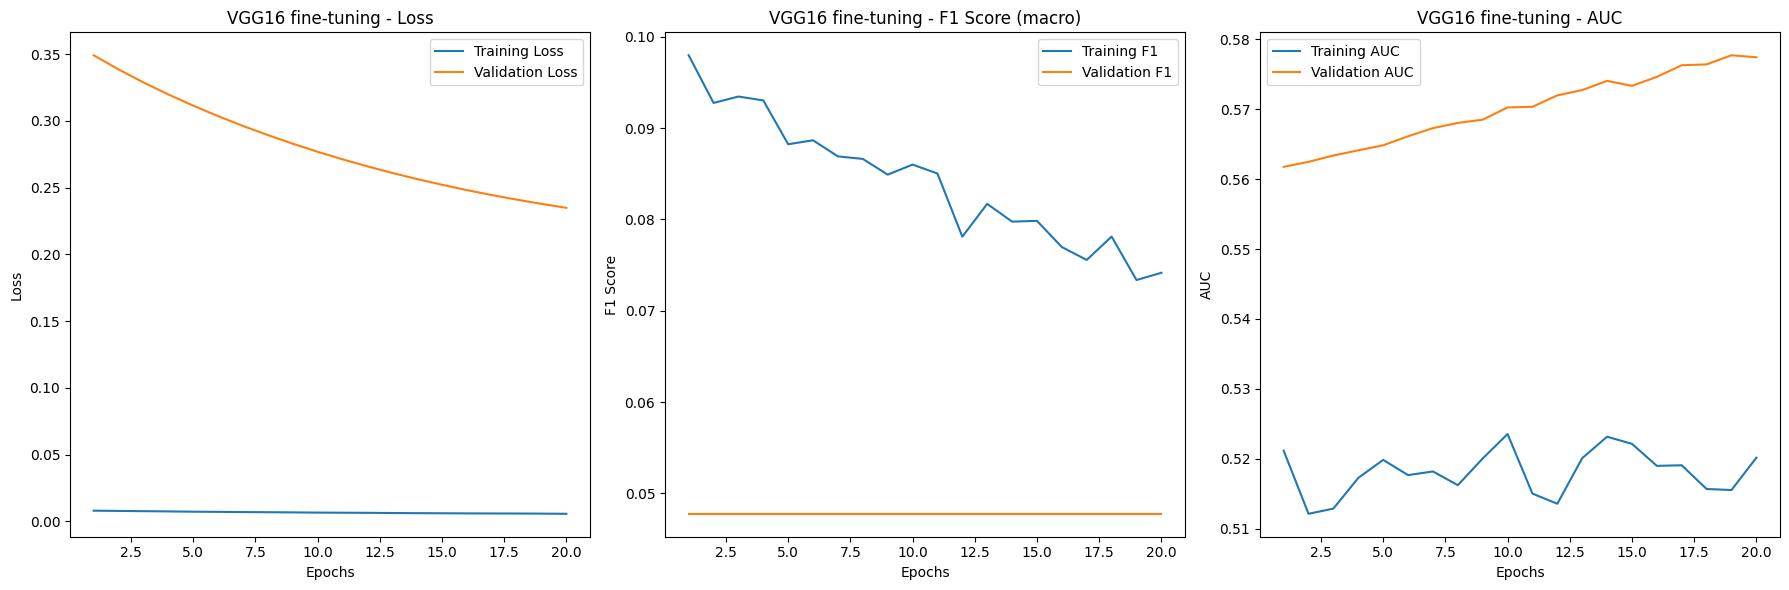

In [182]:
plot_history(history_vgg16_model_2 , "VGG16 fine-tuning")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


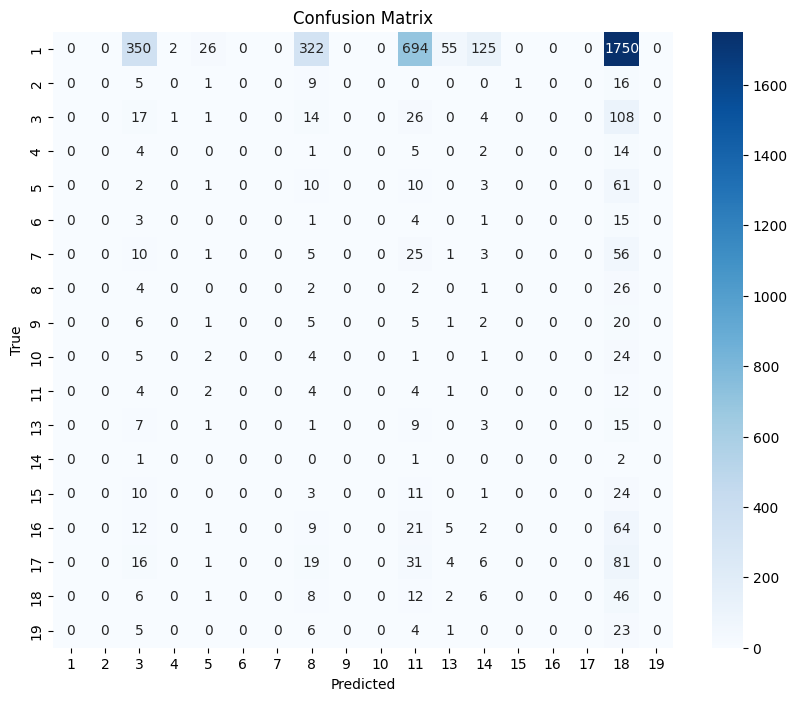

In [183]:
y_true, y_pred = get_true_pred_test(vgg16_finetuned_model_2, test_dataset)
cm = get_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names)

**EfficientNet :**

Expérimentation 1 : Transfert d’apprentissage

In [184]:
from tensorflow.keras.applications import EfficientNetB0

def build_efficientnet_feature_extractor(input_shape=(224, 224, 3), num_classes=18):
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Geler toutes les couches

    # Ajouter une nouvelle tête de classification
    x = Flatten()(base_model.output)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation="sigmoid")(x)  # Multi-label → Sigmoid

    model = Model(inputs=base_model.input, outputs=output)

    return model

# Création du modèle
efficientnet_feature_extractor = build_efficientnet_feature_extractor()
efficientnet_feature_extractor.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 12,080,181 (46.08 MB)

 Trainable params: 8,030,610 (30.63 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [185]:
history_efficientnet_1= compile_and_train(efficientnet_feature_extractor, "EfficientNet transfer learning", weighted_train_dataset, val_dataset, epochs=EPOCHS)


Training EfficientNet transfer learning...

Epoch 1/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 64s 63ms/step - accuracy: 0.3512 - auc: 0.4961 - f1_score: 0.0989 - loss: 0.0099 - val_accuracy: 0.7542 - val_auc: 0.4987 - val_f1_score: 0.0478 - val_loss: 0.2335
Epoch 2/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5630 - auc: 0.4938 - f1_score: 0.0886 - loss: 0.0065 - val_accuracy: 0.7542 - val_auc: 0.4911 - val_f1_score: 0.0478 - val_loss: 0.2232
Epoch 3/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5621 - auc: 0.4957 - f1_score: 0.0872 - loss: 0.0064 - val_accuracy: 0.7542 - val_auc: 0.4967 - val_f1_score: 0.0478 - val_loss: 0.2210
Epoch 4/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5760 - auc: 0.4951 - f1_score: 0.0883 - loss: 0.0063 - val_accuracy: 0.7542 - val_auc: 0.4997 - val_f1_score: 0.0478 - val_loss: 0.2204
Epoch 5/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5759 - auc: 0.5038 - f1_score: 0.0918 - loss: 0.0063 - val_accuracy: 0.

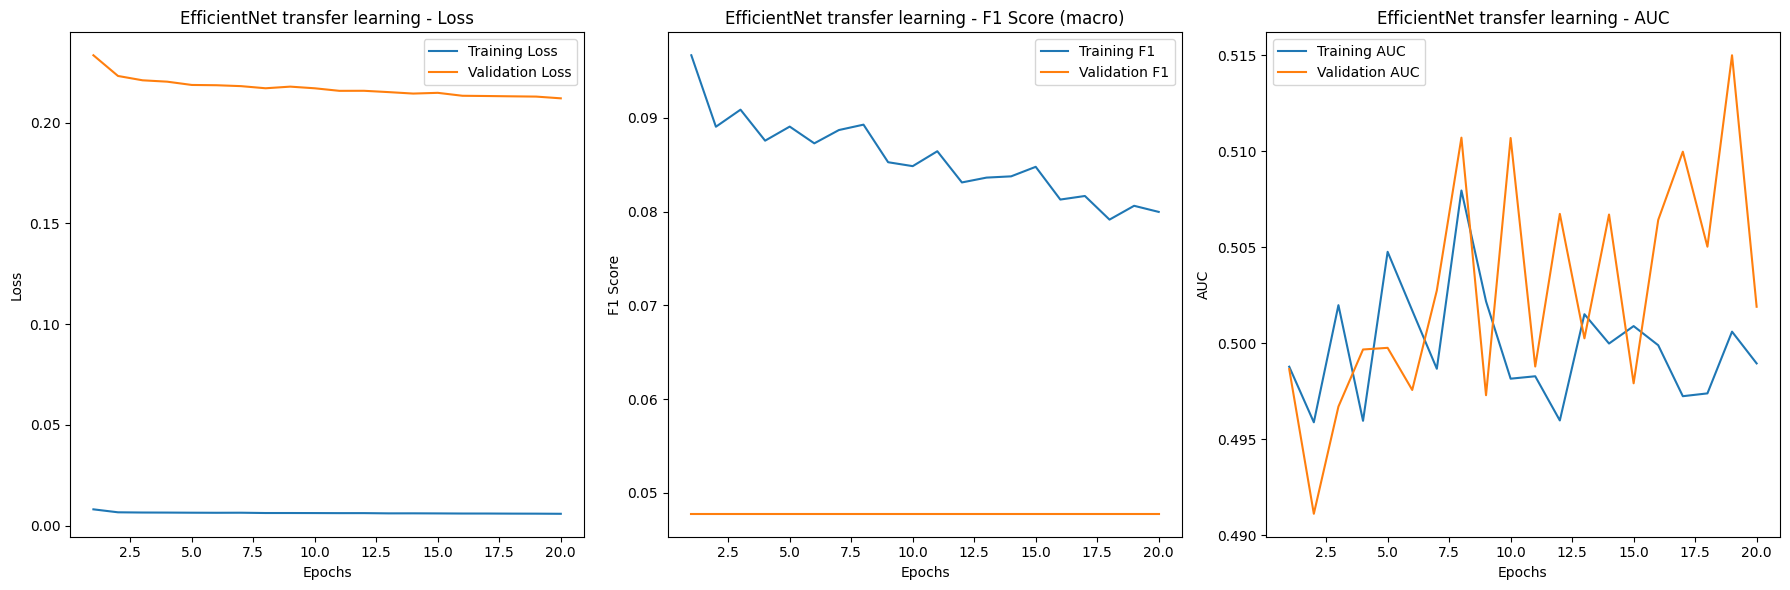

In [186]:
plot_history(history_efficientnet_1 , "EfficientNet transfer learning")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


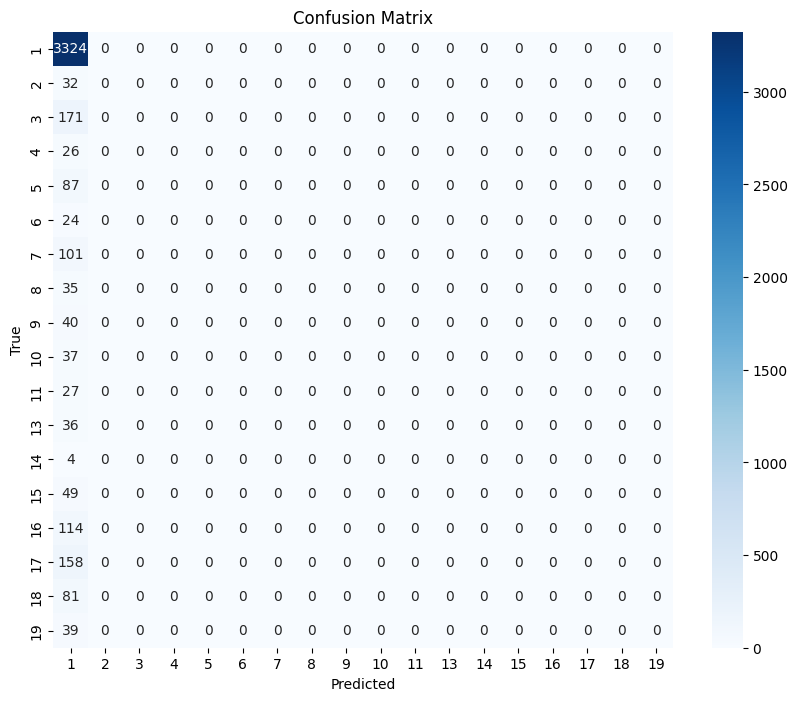

In [187]:
y_true, y_pred = get_true_pred_test(efficientnet_feature_extractor, test_dataset)
cm = get_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names)

Expérimentation 2 : Fine-tuning partiel

In [188]:
def build_efficientnet_fine_tuning(input_shape=(224, 224, 3), num_classes=18):
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)

    # Dégeler les 20 dernières couches
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    # Nouvelle tête de classification
    x = Flatten()(base_model.output)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=output)

    return model

# Création du modèle
efficientnet_fine_tuned = build_efficientnet_fine_tuning()
efficientnet_fine_tuned.summary()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 12,080,181 (46.08 MB)

 Trainable params: 12,038,158 (45.92 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [189]:
history_efficientnet_2= compile_and_train(efficientnet_fine_tuned, "EfficientNet fine-tuning", weighted_train_dataset, val_dataset, epochs=EPOCHS)


Training EfficientNet fine-tuning...

Epoch 1/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 55s 58ms/step - accuracy: 0.6203 - auc: 0.5010 - f1_score: 0.0795 - loss: 0.0058 - val_accuracy: 0.7542 - val_auc: 0.5075 - val_f1_score: 0.0478 - val_loss: 0.2116
Epoch 2/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.6120 - auc: 0.4949 - f1_score: 0.0812 - loss: 0.0057 - val_accuracy: 0.7542 - val_auc: 0.5169 - val_f1_score: 0.0478 - val_loss: 0.2121
Epoch 3/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.6143 - auc: 0.4976 - f1_score: 0.0763 - loss: 0.0057 - val_accuracy: 0.7542 - val_auc: 0.5033 - val_f1_score: 0.0478 - val_loss: 0.2111
Epoch 4/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.6263 - auc: 0.4936 - f1_score: 0.0779 - loss: 0.0057 - val_accuracy: 0.7542 - val_auc: 0.5091 - val_f1_score: 0.0478 - val_loss: 0.2111
Epoch 5/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.6326 - auc: 0.5026 - f1_score: 0.0780 - loss: 0.0056 - val_accuracy: 0.7542 -

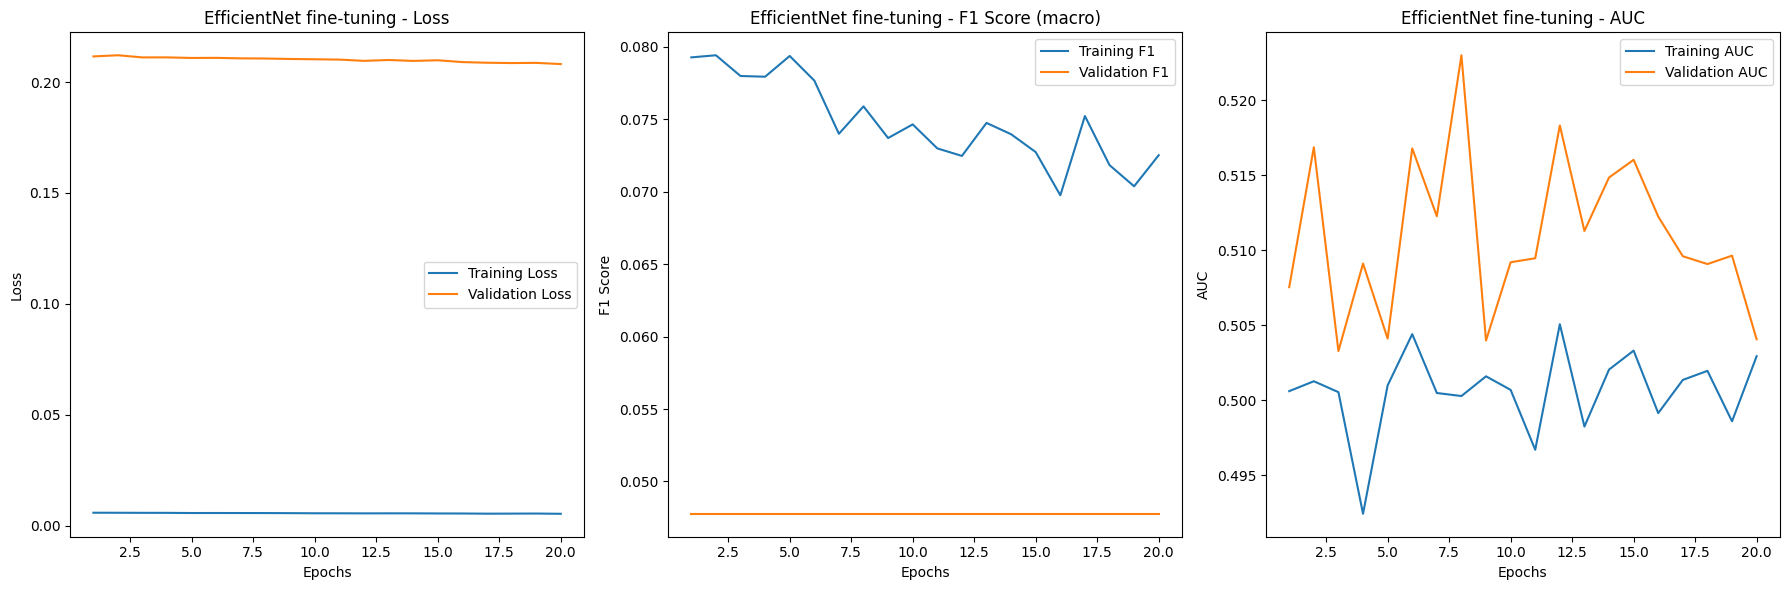

In [190]:
plot_history(history_efficientnet_2 , "EfficientNet fine-tuning")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


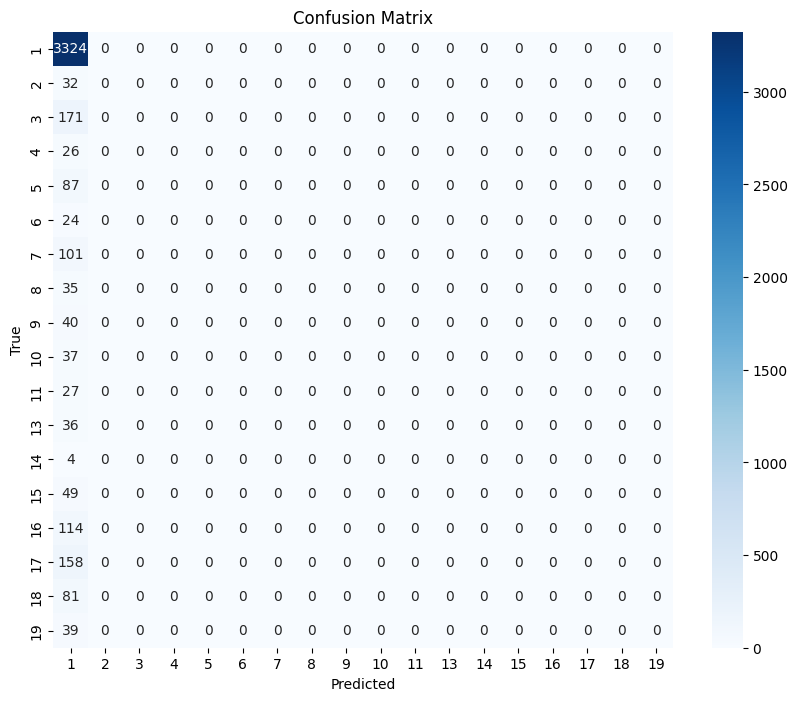

In [191]:
y_true, y_pred = get_true_pred_test(efficientnet_fine_tuned, test_dataset)
cm = get_confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names)